# Hospital Assignment Problem

Every year, a new set of recent medical school graduates need to begin their residency at a hospital. Due to the prestige of certain hospitals, it is generally impossible for all recent graduates to begin residency at their first choice. In order to facilitate a fair assignment process, where each graduate is matched with one hospital, the graduates are usually asked to fill out a preference list, ranking each of the hospitals. Graduates are then matched to hospitals by solving an assignment problem (a balanced transportation problem) where the preferences of the graduates are used to define the costs in the objective function, which we minimize.

For example, consider the case where there are 3 hospitals and 4 people. Then, each person rates one hospital as 1 (their first choice), one hospital as 2, and one hospital as 3. An example preference list would be, where each row is a person and each column is a hospital.
\begin{equation*}
\left[
\begin{matrix}
2 & 1 & 3 \\
1 & 2 & 3 \\
1 & 2 & 3 \\
2 & 3 & 1
\end{matrix}
\right]
\end{equation*}
Here, the first person's first preference is hospital 2, their second preference is hospital 1 and their third preference is hospital 3. Our goal is to satisfy these preferences in the "best" way possible. However, what is "best" is not always clear. Should we maximize the number of people who get their first choice? Or minimize the number that get their third choice? We can get different solutions that favor one approach versus the other by varying how we use these preferences to define the objective function. For example, if we simply use these preferences as the costs (so if person A gets assigned to their first choice, that incurs a cost of 1, their second choice incurs a cost of 2, and their third choice incurs a cost of 3). However, we may get a very different assignment if we use the square of these preferences as the costs (so if person A gets assigned to their first choice, that incurs a cost of 1, their second choice incurs a cost of 4, and their third choice incurs a cost of 9).

In this homework assignment, you will start from **the code in this notebook**. The code inside of the first code block of the notebook generates an example of the hospital assignment problem with 100 people and 5 hospitals. You do not need to modify this block. You will solve this problem 4 times, raising the preference list to the powers 1/4, 1, 2, and 4, as is set up in the second code block. In this second block, you should put the variables and constraints of your model prior to the loop. Inside the loop, you should create the objective function based on the power the preference list is raised to (using the variable preferences defined in there). Then, update the line of code just below optimize!(m) with the name of your decision variable (which should be indexed over [people (1-100), hospitals (1-5)]).

You should formulate this problem as a balanced transportation problem, where each person is assigned to one hospital (provides 1 supply) and each hospital is assigned 20 people (has a demand of 20). Due to the size of this problem, constructing an incidence matrix is a bit unweildy, so you should use the transportation problem form found in Applications\_Transportation slides.

If done properly, the rest of the code will compile the data from the solutions and the third code block will plot the 4 different solutions. **Finally, in Markdown below the final code cell, you should add a brief discussion of which solution you think is "best" and why.**

The code directly below this should run as is (so long as you have the proper libraries; if not, make sure to add them as described in the first comment). This code will set up the matrix of preferences of the 100 people for each of the 5 hospitals and place it in the matrix preferencelist.

In [5]:
#If you have not installed Random before, call
using Pkg
Pkg.add("Random")
using Random

#Set the random seed so this always gives the same results.
#You may change this to different numbers to see the results, but please
#submit using seed 10
Random.seed!(10)

#Number of people
np = 100
#Number of hospitals
nh = 5

#Create a preference list with np rows and nh columns
#(each row is the preferences of 1 person)
preferencelist = zeros(np, nh)
#Generate a random permutation of the numbers 1 through 5
pref = shuffle(1:5)
#Copy this shuffle 60 times (to make the problem difficult to assign)
for i in 1:60
    preferencelist[i,:] = pref
end

#The last 40 preferences are all random permutations
for i in 61:np
    preferencelist[i,:] = shuffle(1:5)
end

#Print out the last 3 rows, to see what this list looks like.
#Each row is a person with 5 entries that rate each of the 5
#hospitals as 1 through 5.
for i in np-2:np
    println(preferencelist[i,:])
end
;

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


[4.0, 1.0, 5.0, 3.0, 2.0]
[1.0, 5.0, 3.0, 4.0, 2.0]
[4.0, 2.0, 1.0, 3.0, 5.0]


The data is set up, so it's time to move onto the model. We will solve this problem 4 times with the same set of variables and constraints but a new objective function each time. The code below has 3 spots where you need to insert or modify it with your model to make it work.

In [8]:
using JuMP, HiGHS

#Powers that we will raise the preference list to
powers = [1/4 1 2 4];

#Create the model
m = Model(HiGHS.Optimizer)
#set_silent suppresses the output during solving
#this is nice when we solve multiple times
set_silent(m)

#Insert the variables and constraints in your model HERE.
#Your decision variables should be a matrix indexed
#by [people,hospitals] (1 entry for each pair), im assuming this means refer to people as 1:np and hospitals as 1:nh

#decision variable

@variable(m, x[1:np, 1:nh] >= 0)

#constraints
# each person has at most one hospital
@constraint(m, [i in 1:np], sum(x[i, j] for j in 1:nh) == 1)

# each hopsital has exactly 20 people
@constraint(m, [j in 1:nh], sum(x[i, j] for i in 1:np) == 20)



#Dictionary that will store the solution. It will map the numbers
#1 through 4 to the 4 different solutions (in terms of the decision
#variables, which should be a matrix).
solution = Dict()

#Keep track of the iteration number (for saving solutions)
iteration = 1
#Loop through all elements in power. Solve a new model each
#time.
for p in powers
    #Raise the preferences list to the power p (elementwise)
    #Use this matrix to define the objective function each time through the loop
    preferences = preferencelist.^p

    #objective
    @objective(m, Min, sum( x[i,j]*preferences[i,j] for i in 1:np, j in 1:nh ) )


    optimize!(m)

    #UPDATE THE CODE BELOW
    #Uncomment this code and insert the name of your
    #decision variable instead of ``mydecisionvariable"

    solution[iteration] = value.(x)

    iteration = iteration+1
end

#If everything was done properly above, the rest of the code should run
#without needing changes

#Set up a matrix with nh rows and 4 columns
#Each column is the solution for a different power,
#where the number of people who were assigned their first choice
#are in row 1, the number of people who were assigned their
#second choice are in row 2, etc.
preferencecount = zeros(nh,length(powers))
for k in 1:length(powers)
    #Look at the k-th solution, should be a matrixed
    #indexed over [people,hospitals]
    soln = solution[k]

    #Loop through the soln matrix
    for i in 1:np
        for j in 1:nh
            #If the current element we are looking at has an entry of 1
            #(so it was chosen as part of the assignment)
            if(abs(soln[i,j]-1) <= 10^-6)
                #Determine what preference this person had for this assignment
                #(should be a number 1-5).
                pref = convert(Int64,preferencelist[i,j])
                #Increase the entry in preferencecount for that preference
                #(For example, if this assignment had a preference of 3 and we have seen
                #1 3 previously, this updates the count to 2 3's having been seen)
                preferencecount[pref,k] = preferencecount[pref,k] + 1
            end
        end
    end
end

#Show the preference count as a matrix. First row is number
#of people assigned their first preference for the 4 different trials,
#the second row is the number of people assigned their second preference...
for i in 1:nh
    println(preferencecount[i,:])
end

[49.0, 44.0, 42.0, 36.0]
[25.0, 32.0, 33.0, 34.0]
[12.0, 13.0, 17.0, 27.0]
[11.0, 11.0, 8.0, 3.0]
[3.0, 0.0, 0.0, 0.0]


Now let's plot the different solutions.

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


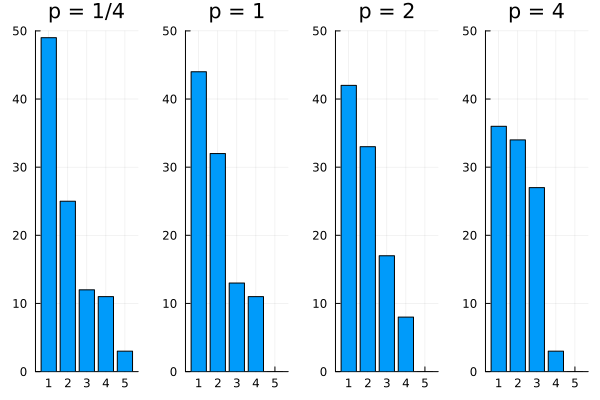

In [9]:
#If you have not installed plots before, run
using Pkg
Pkg.add("Plots")
using Plots

#Generate bar plots of each solution. Notice how the solution changes
#as we raise the preferences to a higher power
p1 = bar(1:5, preferencecount[:,1], title = "p = 1/4", ylims = (0,50))
p2 = bar(1:5, preferencecount[:,2], title = "p = 1", ylims = (0,50))
p3 = bar(1:5, preferencecount[:,3], title = "p = 2", ylims = (0,50))
p4 = bar(1:5, preferencecount[:,4], title = "p = 4", ylims = (0,50))
plot(p1, p2, p3, p4, layout = (1, 4), legend = false)

Which solution do you feel is the most fair or gives the "best" solution? Explain in this Markdown cell:




I think that the most fair would be p=4 as then people don't get their last option and more than 50% get their first 2 choices compared to the others. While p=1/4 does let most people get nearly 50 their first choice, a lot are at the latter half of their preferences, so the most fair would be p=4 as it seems to have more even/equal distribution/chance.